tmp# World Data League 2021
## Notebook Template

This notebook is one of the mandatory deliverables when you submit your solution (alongside the video pitch). Its structure follows the WDL evaluation criteria and it has dedicated cells where you can add descriptions. Make sure your code is readable as it will be the only technical support the jury will have to evaluate your work.

The notebook must:

*   💻 have all the code that you want the jury to evaluate
*   🧱 follow the predefined structure
*   📄 have markdown descriptions where you find necessary
*   👀 be saved with all the output that you want the jury to see
*   🏃‍♂️ be runnable


## Authors
Write the name (first and last) of the people on your team that are responsible for developing this solution.

## External links and resources
Paste here all the links to external resources that are necessary to understand and run your code. Add descriptions to make it clear how to use them during evaluation.

## Introduction
Describe how you framed the challenge by telling us what problem are you trying to solve and how your solution solves that problem.

## Development
Start coding here! 👩‍💻

Don't hesitate to create markdown cells to include descriptions of your work where you see fit, as well as commenting your code.

We know that you know exactly where to start when it comes to crunching data and building models, but don't forget that WDL is all about social impact...so take that into consideration as well.

In [1]:
# Imports and helper functions for loading data

import shapefile
import pandas as pd
import glob

def read_shapefile(shp_path):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' column holding
    the geometry information. This uses the pyshp package
    """

    #read file, parse out the records and shapes
    sf = shapefile.Reader(shp_path)
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]

    #write into a dataframe
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)

    return df

def load_noise_data(file_paths, sensor_list):
    """
    Function for loading noise data into the correct format
    """
    concat_data = []
    for file in file_paths:
        df = pd.read_csv(file, header=8, sep=';')
        df = df.melt(id_vars=['Data', 'Ora'])
        df['Timestamp'] = pd.to_datetime(df['Data'] + ' ' + df['Ora'])
        df.columns = ['Date', 'Time', 'Sensor_ID', 'Intensity', 'Timestamp']
        df['Intensity'] = df['Intensity'].str.replace(',', '.').astype(float)

        concat_data.append(df)

    concat_df = pd.concat(concat_data)

    output = concat_df.merge(sensor_list, on=['Sensor_ID'])
    return output[['Timestamp', 'Sensor_ID', 'Intensity', 'address', 'Lat', 'Long', 'day_max_db', 'night_max_db', 'area_type']]

In [2]:
# Load list of sensors

sensor_list = pd.read_csv('data/noise_sensor_list.csv', sep = ';')
sensor_list['Sensor_ID'] = ['C1', 'C2', 'C3', 'C4', 'C5']
sensor_list['Lat'] = sensor_list['Lat'].str.replace(',', '.').astype(float)
sensor_list['Long'] = sensor_list['Long'].str.replace(',', '.').astype(float)

# Get mapping locations and correspondence to area type
# Link: https://webgis.arpa.piemonte.it/Geoviewer2D/?config=other-configs/acustica_config.json

mapping_location_area_code = pd.DataFrame(
    [['s_01', 65, 55, 'IV - Aree di intensa attività umana'],
    ['s_02', 60, 50, 'III - Aree di tipo misto'],
    ['s_03', 60, 50, 'III - Aree di tipo misto'],
    ['s_05', 65, 55, 'IV - Aree di intensa attività umana'],
    ['s_06', 60, 50, 'III - Aree di tipo misto']],
    columns=['code', 'day_max_db', 'night_max_db', 'area_type']
)

sensor_list = sensor_list.merge(mapping_location_area_code, on=['code'])

In [3]:
sensor_list.head(3)

,code,address,Lat,Long,streaming,Sensor_ID,day_max_db,night_max_db,area_type
0,s_01,"Via Saluzzo, 26 Torino",45.059172,7.678986,https://userportal.smartdatanet.it/userportal/...,C1,65,55,IV - Aree di intensa attività umana
1,s_02,"Via Principe Tommaso, 18bis Torino",45.057837,7.681555,https://userportal.smartdatanet.it/userportal/...,C2,60,50,III - Aree di tipo misto
2,s_03,Largo Saluzzo Torino,45.058518,7.678854,https://userportal.smartdatanet.it/userportal/...,C3,60,50,III - Aree di tipo misto


In [4]:
file_paths_noise_data = ['data/noise_data/san_salvario_2017.csv']

data = load_noise_data(file_paths_noise_data, sensor_list)

In [5]:
# Police complaints

file_paths=glob.glob('data/police_complaints/*.csv')

concat_data = []
for file in file_paths:
    df = pd.read_csv(file, sep=',')
    df['Timestamp'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
    concat_data.append(df)
df_final = pd.concat(concat_data)

filter = ['Facilities disturbances', 'Disturbing noises', 'Youth aggregation']
df_filtered = df_final.loc[df_final['Criminal sub-category'].isin(filter)]

df_filtered_san_salvario = df_filtered[df_filtered.District == 8]

df_filtered_san_salvario['Localization'] = df_filtered_san_salvario['Localization'].str.lower().str.strip()

<ipython-input-5-6197e77966b6>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_san_salvario['Localization'] = df_filtered_san_salvario['Localization'].str.lower().str.strip()


In [6]:
# TODO Joana: Fazer mapeamento manual usando o código:

# df_filtered_san_salvario str contains Tommaso
# df_filtered_san_salvario str contains saluzzo (largo)
# df_filtered_san_salvario str contains baretti
# df_filtered_san_salvario str contains marconi 
localization_address_mapping = {
   'saluzzo/(via)':  'Via Saluzzo, 26 Torino'
}

In [7]:
df_filtered_san_salvario['address'] = df_filtered_san_salvario['Localization'].map(localization_address_mapping)

<ipython-input-7-e10d5282f209>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_san_salvario['address'] = df_filtered_san_salvario['Localization'].map(localization_address_mapping)


In [8]:
tmp = df_filtered_san_salvario.merge(data, on=['address'])

# Filtrar as linhas em que timestamp_x >= timestamp_y + 1 dia 

# Criar um pandas Series / dicionario que tenha como chave o dia/timestamp no qual houve uma queixa no mesmo dia ou no dia seguinte (que vai ser a label=1)
# label = 0 vão ser os dias em que não se conseguiu mapear nada

In [9]:
# Filtrar dataset de treino para as datas

# Exploratory Data Analysis

## Sensor Location

TODO: Description here about the sensors' proximity

In [10]:
import folium

m = folium.Map(location=[45.0530, 7.6798], zoom_start=15)

for indice, row in sensor_list.iterrows():
    folium.Marker(
        location=[row["Lat"], row["Long"]],
        popup=row['address'],
        icon=folium.Icon(color="red", icon='automobile', prefix='fa')
        ).add_to(m)

m

## Sazonality and regular behavior studies

In [11]:
import holidays
import numpy as np

it_holidays = holidays.CountryHoliday('Italy')

# We created a function to get some interesting date features, based on Pandas DataSeries predefined functions
def get_date_features(df_resampled, date_col, suffix, holidays_list):
    """
    Function for getting date features from a datetime column. 
    """
    df_resampled[f'day_{suffix}'] = df_resampled[date_col].dt.day
    df_resampled[f'hour_{suffix}'] = df_resampled[date_col].dt.hour
    df_resampled[f'month_{suffix}'] = df_resampled[date_col].dt.month
    df_resampled[f'dayofweek_{suffix}'] = df_resampled[date_col].dt.dayofweek
    # df_resampled[f'year_{suffix}'] = df_resampled[date_col].dt.year
    df_resampled[f'quarter_{suffix}'] = df_resampled[date_col].dt.quarter
    df_resampled[f'is_holiday_{suffix}'] = df_resampled[date_col].apply(lambda x: x in holidays_list)
    # df_resampled[f'is_year_end_{suffix}'] = df_resampled[date_col].dt.is_year_end
    df_resampled[f'is_weekend_{suffix}'] = np.where(df_resampled[f'dayofweek_{suffix}'].isin([5, 6]), 1, 0)
                                                  
    return df_resampled

data = get_date_features(data, date_col='Timestamp', suffix='now', holidays_list=it_holidays)

In [12]:
def noise_threshold(data, date_col='hour_now', suffix='now', value_col='Intensity'):
    mask_day = (data[date_col] > 6) & (data[date_col] < 22) & (data[value_col] > data['day_max_db'])
    mask_night = (data[date_col] > 22) | (data[date_col] < 6) & (data[value_col] > data['night_max_db'])
    mask = mask_day | mask_night

    data[f'noise_exceeds_threshold_{suffix}'] = np.where(mask, 1, 0)
    
    return data

In [13]:
data = noise_threshold(data, date_col='hour_now', suffix='now', value_col='Intensity')

In [14]:
def dbmean(levels, axis=None):
    """
    Energetic average of levels.
    :param levels: Sequence of levels.
    :param axis: Axis over which to perform the operation.
    .. math:: L_{mean} = 10 \\log_{10}{\\frac{1}{n}\\sum_{i=0}^n{10^{L/10}}}
    """
    # levels = np.asanyarray(levels)
    return 10.0 * np.log10((10.0**(levels / 10.0)).mean(axis=axis))

In [15]:
avg_intensity_per_hour = data[data.Sensor_ID == 'C1'].groupby('hour_now')['Intensity'].apply(dbmean)

Text(0.5, 0, 'Hour of day (h)')

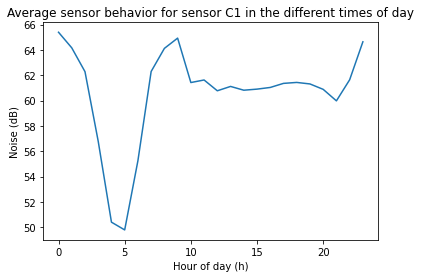

In [16]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(avg_intensity_per_hour)), avg_intensity_per_hour.values)
plt.title('Average sensor behavior for sensor C1 in the different times of day')
plt.ylabel('Noise (dB)')
plt.xlabel('Hour of day (h)')

In [17]:
# We create a function to create our targets
# As you can see, we created our target (label) based on a date offset (i.e., our label will be the intensity of the next day at the same time)
def create_target(df_resampled, date_col = 'Timestamp', target_col = 'Intensity', entity_id='Sensor_ID', date_offset = 24):
    """
    Function from creating lagged or future features for a specific date offset.
    For instance, this adds a new column with the intensity values 24 hours in the future, for each row, by default.    
    """
    
    df_resampled[f'date_col_{target_col}'] = df_resampled[date_col] + pd.DateOffset(hours=date_offset)
    tmp = df_resampled[[entity_id, date_col, f'date_col_{target_col}', target_col]].merge(
        df_resampled[[entity_id, date_col, f'date_col_{target_col}', target_col]], 
        left_on = [entity_id, f'date_col_{target_col}'], 
        right_on=[entity_id, date_col], 
        how='left'
    )

    tmp = tmp[[entity_id, f'{date_col}_x', f'{target_col}_y']]
    tmp.columns = [entity_id, date_col, f'target_{target_col}_{str(date_offset)}h']

    df_resampled = df_resampled.merge(tmp, on=[entity_id, date_col])
    
    return df_resampled

In [18]:
data = create_target(data, target_col='Intensity', date_offset=24)

In [19]:
data = get_date_features(data, date_col='date_col_Intensity', suffix='target', holidays_list=it_holidays)


In [20]:
data = noise_threshold(data, date_col='hour_target', suffix='target', value_col='target_Intensity_24h')

In [21]:
# Avg noise intensity next 3 hours

#indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=3)
#data['average_intensity_next_3h'] = data.groupby(['Sensor_ID'])['Intensity'].rolling(window=indexer, min_periods=1).agg(dbmean).reset_index()['Intensity']
# data = noise_threshold(data, date_col='hour_target', suffix='target_2')


## Train first model

In [22]:
# We create a list of columns that we do not need to train our model
COLS_TO_REMOVE = [
    'Timestamp',
    'Sensor_ID',
    'address',
    'Lat',
    'Long',
    'area_type',
    'target_Intensity_24h',
    'date_col_Intensity',
    'noise_exceeds_threshold_target',
    #'average_intensity_next_3h',
    #'noise_exceeds_threshold_target_2'
]

# Based on the previous list, we create a new list with the features that we actually need!
COLS_TO_KEEP = [x for x in data.columns if x not in COLS_TO_REMOVE]

In [23]:
COLS_TO_REMOVE

['Timestamp',
 'Sensor_ID',
 'address',
 'Lat',
 'Long',
 'area_type',
 'target_Intensity_24h',
 'date_col_Intensity',
 'noise_exceeds_threshold_target']

In [24]:
data = data.sort_values(by= ['Timestamp', 'Sensor_ID']).reset_index(drop=True)

In [25]:
target_1 = 'target_Intensity_24h'

from xgboost import XGBClassifier

# Train model
# Please note that we use 80% of the data set as our train set!
X_train = data[0:int(0.7*len(data))]

# We remove the NaNs (labels that are NaNs)
X_train = X_train[~X_train[target_1].isna()]

# We use the remaining 20% as test set
X_test = data[int(0.7*len(data)):]

# We remove the NaNs (labels that are NaNs)
X_test = X_test[~X_test[target_1].isna()]

# Our labels column
y_train = X_train['noise_exceeds_threshold_target']

# We train an XGBoost Regressor. 
# Since it is a decision tree, it becomes easier to explain the decisions of our model
xgb = XGBClassifier(n_estimators=100)

# We train our model
xgb.fit(X_train[COLS_TO_KEEP].fillna(9999).astype(float), y_train)

y_pred = xgb.predict_proba(X_test[COLS_TO_KEEP].fillna(9999).astype(float))
X_test['pred_score'] = y_pred[:, 1]

C:\Users\paulo\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:07:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [26]:
X_train.Timestamp.max(), X_test.Timestamp.min()

(Timestamp('2017-09-13 11:00:00'), Timestamp('2017-09-13 11:00:00'))

In [27]:
X_test[(X_test.noise_exceeds_threshold_target == 1)][['Timestamp', 'Sensor_ID', 'Intensity', 'target_Intensity_24h']]

,Timestamp,Sensor_ID,Intensity,target_Intensity_24h
30659,2017-09-13 11:00:00,C5,63.6,63.6
30661,2017-09-13 12:00:00,C2,61.1,60.8
30664,2017-09-13 12:00:00,C5,64.2,64.2
30669,2017-09-13 13:00:00,C5,63.6,63.1
30671,2017-09-13 14:00:00,C2,60.6,60.7
...,...,...,...,...
43547,2017-12-29 21:00:00,C3,57.0,64.1
43549,2017-12-29 21:00:00,C5,61.0,61.6
43555,2017-12-29 23:00:00,C1,62.6,64.9
43557,2017-12-29 23:00:00,C3,67.4,66.2


In [28]:
from sklearn.metrics import roc_auc_score

print("ROC AUC", roc_auc_score(X_test['noise_exceeds_threshold_target'], y_pred[:, 1]))

ROC AUC 0.9448021019930358


In [29]:
import shap
# Shap explanation

# We now explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test[COLS_TO_KEEP].fillna(9999).astype(float))

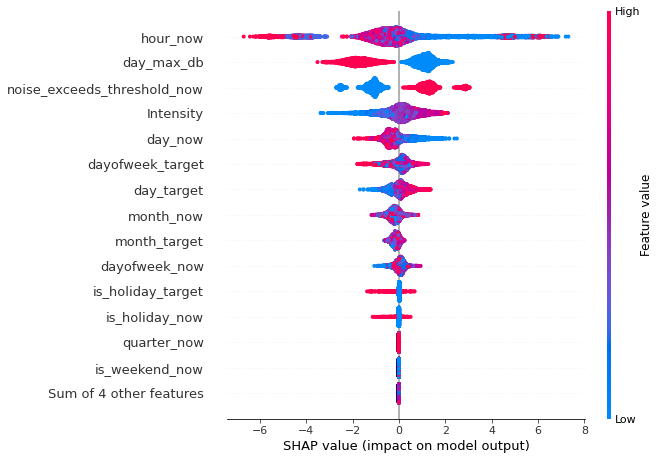

In [30]:
# Let's get a nice plot with the shap values so you can have an intuition on the rationale behind the model learned by the XGBoost Regressor
shap.plots.beeswarm(shap_values, max_display=15)

## Conclusions

### Scalability and Impact
Tell us how applicable and scalable your solution is if you were to implement it in a city. Identify possible limitations and measure the potential social impact of your solution.

### Future Work
Now picture the following scenario: imagine you could have access to any type of data that could help you solve this challenge even better. What would that data be and how would it improve your solution? 🚀